# Creating Custom Models (Advanced)

## Overview

This tutorial shows you how to create fully custom sequential sampling models in `ssm-simulators`. You'll learn to:

- Define custom boundary functions
- Create custom drift functions
- Apply parameter sampling constraints
- Use theta processors for parameter preparation
- Register complete custom models

In [ ]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# ssms imports
from ssms.config import ConfigBuilder
from ssms.config import (
    register_boundary,
    register_drift,
    register_model_config,
    get_boundary_registry,
    get_drift_registry,
    get_model_registry,
)
from ssms.basic_simulators import Simulator
import ssms.basic_simulators.boundary_functions as bf
import ssms.basic_simulators.drift_functions as df

## Section 1: Introduction - Levels of Customization

There are multiple levels at which you can customize models:

<div style="max-width: 800px; margin: 30px auto;">
  <table style="width: 100%; border-collapse: separate; border-spacing: 0;">
    <tr>
      <td style="padding: 20px; background-color: #e8f5e9; border: 3px solid #2e7d32; border-radius: 8px; margin-bottom: 10px;">
        <div style="font-weight: 700; font-size: 16px; margin-bottom: 10px; color: #1b5e20;">✅ Level 1: Use Built-in Boundaries & Drift</div>
        <div style="font-size: 13px; color: #555; line-height: 1.8;">
          Choose from existing boundary and drift functions<br/>
          <em>Easiest - covered in Tutorial 03</em>
        </div>
      </td>
    </tr>
  </table>
  
  <div style="text-align: center; font-size: 20px; color: #666; margin: 10px 0;">↓</div>
  
  <table style="width: 100%; border-collapse: separate; border-spacing: 0;">
    <tr>
      <td style="padding: 20px; background-color: #fff3e0; border: 3px solid #f57c00; border-radius: 8px;">
        <div style="font-weight: 700; font-size: 16px; margin-bottom: 10px; color: #e65100;">🔧 Level 2: Define Custom Boundary/Drift Functions</div>
        <div style="font-size: 13px; color: #555; line-height: 1.8;">
          Create your own boundary or drift functions<br/>
          Register them in the system<br/>
          <em>Moderate - Section 2 & 3</em>
        </div>
      </td>
    </tr>
  </table>
  
  <div style="text-align: center; font-size: 20px; color: #666; margin: 10px 0;">↓</div>
  
  <table style="width: 100%; border-collapse: separate; border-spacing: 0;">
    <tr>
      <td style="padding: 20px; background-color: #e3f2fd; border: 3px solid #1976d2; border-radius: 8px;">
        <div style="font-weight: 700; font-size: 16px; margin-bottom: 10px; color: #0d47a1;">🎯 Level 3: Add Parameter Sampling Constraints</div>
        <div style="font-size: 13px; color: #555; line-height: 1.8;">
          Enforce constraints or apply transformations<br/>
          Create custom constraint functions or classes<br/>
          <em>Moderate - Section 4</em>
        </div>
      </td>
    </tr>
  </table>
  
  <div style="text-align: center; font-size: 20px; color: #666; margin: 10px 0;">↓</div>
  
  <table style="width: 100%; border-collapse: separate; border-spacing: 0;">
    <tr>
      <td style="padding: 20px; background-color: #f3e5f5; border: 3px solid #7b1fa2; border-radius: 8px;">
        <div style="font-weight: 700; font-size: 16px; margin-bottom: 10px; color: #4a148c;">⚙️ Level 4: Use Parameter Simulator Adapters</div>
        <div style="font-size: 13px; color: #555; line-height: 1.8;">
          Prepare parameters before simulation<br/>
          Handle array dimensions, defaults, renaming<br/>
          <em>Advanced - Section 5</em>
        </div>
      </td>
    </tr>
  </table>
  
  <div style="text-align: center; font-size: 20px; color: #666; margin: 10px 0;">↓</div>
  
  <table style="width: 100%; border-collapse: separate; border-spacing: 0;">
    <tr>
      <td style="padding: 20px; background-color: #ffebee; border: 3px solid #c62828; border-radius: 8px;">
        <div style="font-weight: 700; font-size: 16px; margin-bottom: 10px; color: #b71c1c;">🚀 Level 5: Full Custom Model</div>
        <div style="font-size: 13px; color: #555; line-height: 1.8;">
          Combine all components<br/>
          Register complete custom model<br/>
          <em>Advanced - Section 6</em>
        </div>
      </td>
    </tr>
  </table>
</div>

**This tutorial covers Levels 2-5.** Let's get started!

## Section 2: Custom Boundary Functions

### 2.1 Understanding Boundary Functions

Boundary functions define how decision thresholds behave over time. The signature is:

```python
def boundary_function(t, **params) -> float:
    """
    Args:
        t: Time (float or array)
        **params: Boundary-specific parameters
    
    Returns:
        Boundary value at time t
    """
```

**Key points:**
- Boundaries can be **multiplicative** (scaled by `a` parameter) or **additive** (shifted by `a`)
- Must handle both scalar and array `t` inputs
- Return values should be compatible with numpy operations

### 2.2 Creating a Custom Boundary

Let's create an exponential decay boundary: `boundary(t) = exp(-decay_rate * t) + offset`

This creates a boundary that starts high and exponentially decays to a baseline.

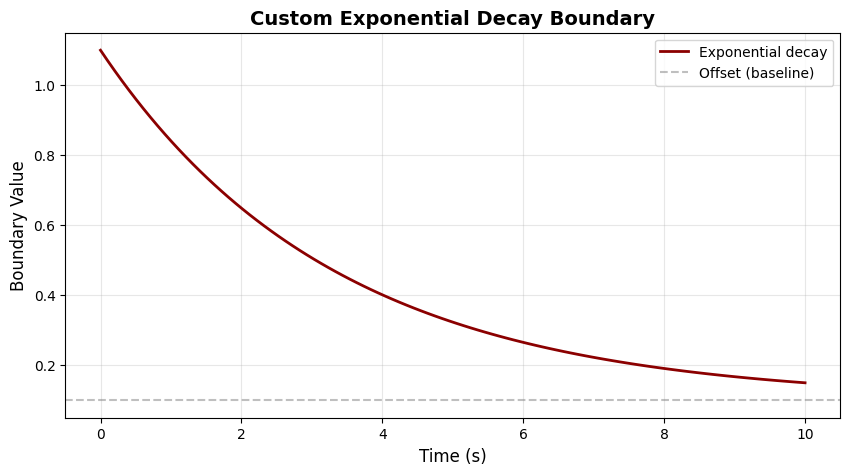

✓ Custom boundary function created and tested!


In [2]:
# Define a custom boundary function
def exponential_decay(t, decay_rate=0.1, offset=0.0):
    """Exponentially decaying boundary.
    
    Args:
        t: Time (float or array)
        decay_rate: Rate of exponential decay (higher = faster decay)
        offset: Minimum boundary value (baseline)
    
    Returns:
        Boundary value at time t
    
    Example:
        At t=0: boundary = 1 + offset
        As t→∞: boundary → offset
    """
    return np.exp(-decay_rate * t) + offset

# Test the function
t_test = np.linspace(0, 10, 100)
boundary_values = exponential_decay(t_test, decay_rate=0.3, offset=0.1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(t_test, boundary_values, linewidth=2, color='darkred', label='Exponential decay')
plt.axhline(y=0.1, linestyle='--', color='gray', alpha=0.5, label='Offset (baseline)')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Boundary Value', fontsize=12)
plt.title('Custom Exponential Decay Boundary', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("✓ Custom boundary function created and tested!")

### 2.3 Registering the Boundary

Now that you've created your custom boundary function, you can register it at runtime using the registry system.

**No package editing required!** Just use `register_boundary()` to make your boundary available system-wide.

In [ ]:
# Register the custom boundary - it's now available system-wide!
register_boundary(
    name="exponential_decay",
    function=exponential_decay,
    params=["decay_rate", "offset"],
    multiplicative=True  # Boundary is scaled by 'a' parameter
)

print("✓ Custom boundary registered!")
print(f"  Name: 'exponential_decay'")
print(f"  Parameters: ['decay_rate', 'offset']")
print()

# Verify registration
registry = get_boundary_registry()
print(f"✓ Available boundaries ({len(registry.list_boundaries())} total):")
print(f"  {registry.list_boundaries()}")
print()
print("Your custom boundary can now be used with ConfigBuilder.add_boundary()!")

Registration syntax for ssms/config/_modelconfig/base.py:

# In ssms/basic_simulators/boundary_functions.py, add:
def exponential_decay(t, decay_rate=0.1, offset=0.0):
    return np.exp(-decay_rate * t) + offset

# In ssms/config/_modelconfig/base.py, add to boundary_config dict:
boundary_config = {
    # ... existing entries ...
    "exponential_decay": {
        "fun": bf.exponential_decay,
        "params": ["decay_rate", "offset"],
        "multiplicative": True,  # or False for additive
    },
}


✓ Once registered, you can use it in model configs!


### 2.4 Using Your Custom Boundary

Once registered, you can use `ConfigBuilder` to add your boundary to models:

In [ ]:
# Use your registered boundary with ConfigBuilder!
custom_model = ConfigBuilder.from_model("ddm")
custom_model = ConfigBuilder.add_boundary(
    custom_model,
    "exponential_decay",  # Using our custom registered boundary
)

print("✓ Created DDM with custom exponential decay boundary:")
print(f"  Boundary name: {custom_model.get('boundary_name')}")
print(f"  Boundary params: {custom_model.get('boundary_params')}")
print(f"  Multiplicative: {custom_model.get('boundary_multiplicative')}")
print()
print("The custom boundary works just like any built-in boundary!")

Created DDM with collapsing bounds:
  Boundary name: angle
  Boundary params: ['theta']


### 2.5 Testing Your Boundary

Always test your boundary by simulating and visualizing results:

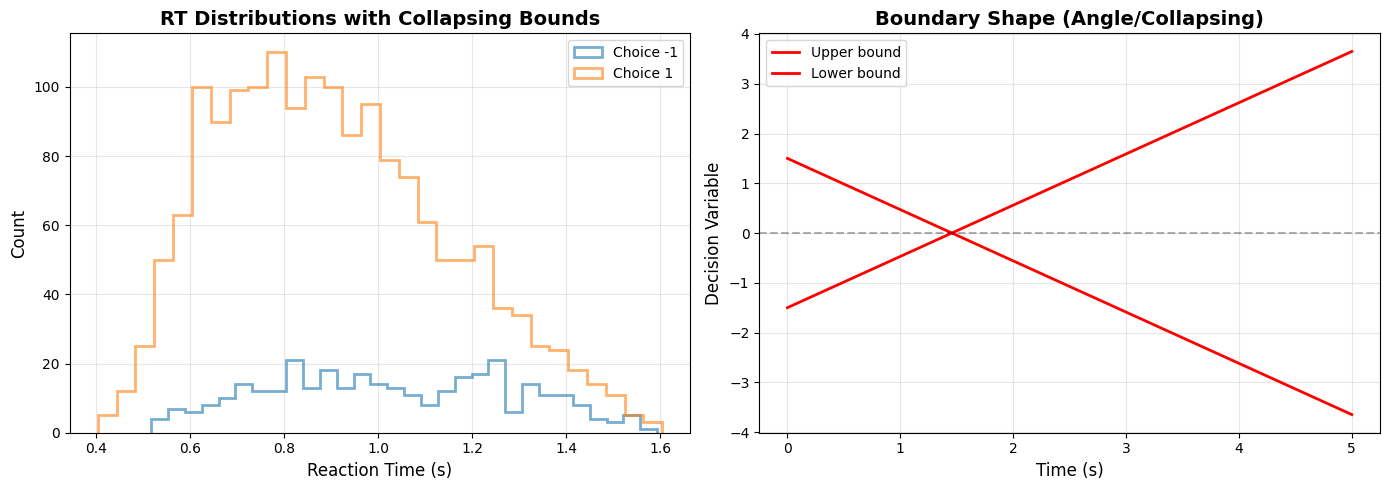


✓ Simulation successful!
Mean RT: 0.925s
Choice proportions: {np.int32(-1): np.int64(330), np.int32(1): np.int64(1670)}


In [ ]:
# Simulate with the custom boundary model
sim = Simulator(model=custom_model)

# Simulate with custom boundary parameters
data = sim.simulate(
    theta={"v": 1.0, "a": 1.5, "z": 0.5, "t": 0.3, "decay_rate": 0.3, "offset": 0.1},
    n_samples=2000
)

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RT histogram
for choice in [-1, 1]:
    mask = data['choices'] == choice
    rts = np.abs(data['rts'][mask])
    axes[0].hist(rts, bins=30, alpha=0.6, label=f'Choice {choice}', histtype='step', linewidth=2)

axes[0].set_xlabel('Reaction Time (s)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('RT Distributions with Exponential Decay Bounds', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Show the custom boundary over time
t_viz = np.linspace(0, 5, 100)
decay_rate_val = 0.3
offset_val = 0.1
a_param = 1.5
boundary_viz = exponential_decay(t_viz, decay_rate=decay_rate_val, offset=offset_val)

axes[1].plot(t_viz, a_param * boundary_viz, 'r-', linewidth=2, label='Upper bound')
axes[1].plot(t_viz, -a_param * boundary_viz, 'r-', linewidth=2, label='Lower bound')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[1].set_xlabel('Time (s)', fontsize=12)
axes[1].set_ylabel('Decision Variable', fontsize=12)
axes[1].set_title('Custom Exponential Decay Boundary', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Simulation successful with custom boundary!")
print(f"Mean RT: {np.mean(np.abs(data['rts'])):.3f}s")
print(f"Choice proportions: {dict(zip(*np.unique(data['choices'], return_counts=True)))}")

## Section 3: Custom Drift Functions

### 3.1 Understanding Drift Functions

Drift functions define how evidence accumulates over time. The signature is:

```python
def drift_function(t, **params) -> float:
    """
    Args:
        t: Time (float or array)
        **params: Drift-specific parameters
    
    Returns:
        Drift rate at time t
    """
```

### 3.2 Creating a Custom Drift

Let's create a sinusoidal drift: `drift(t) = baseline + amplitude * sin(2π * frequency * t)`

This creates oscillating evidence accumulation, useful for modeling rhythmic processes.

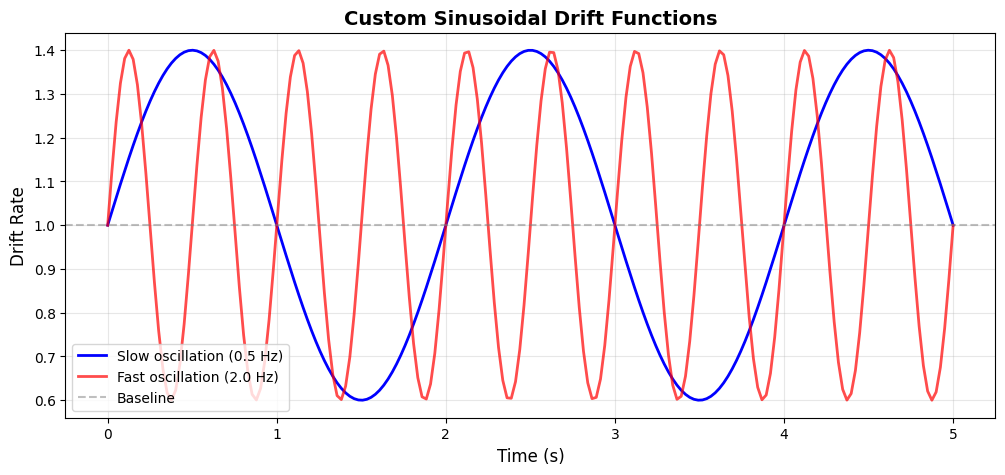

✓ Custom drift function created and tested!


In [6]:
# Define a custom drift function
def sinusoidal_drift(t, frequency=1.0, amplitude=0.5, baseline=1.0):
    """Sinusoidal drift rate.
    
    Args:
        t: Time (float or array)
        frequency: Oscillation frequency (Hz)
        amplitude: Oscillation amplitude
        baseline: Baseline drift rate
    
    Returns:
        Drift rate at time t
    
    Example:
        baseline=1.0, amplitude=0.5 creates drift oscillating between 0.5 and 1.5
    """
    return baseline + amplitude * np.sin(2 * np.pi * frequency * t)

# Test the function
t_test = np.linspace(0, 5, 200)
drift_slow = sinusoidal_drift(t_test, frequency=0.5, amplitude=0.4, baseline=1.0)
drift_fast = sinusoidal_drift(t_test, frequency=2.0, amplitude=0.4, baseline=1.0)

plt.figure(figsize=(12, 5))
plt.plot(t_test, drift_slow, linewidth=2, color='blue', label='Slow oscillation (0.5 Hz)')
plt.plot(t_test, drift_fast, linewidth=2, color='red', alpha=0.7, label='Fast oscillation (2.0 Hz)')
plt.axhline(y=1.0, linestyle='--', color='gray', alpha=0.5, label='Baseline')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Drift Rate', fontsize=12)
plt.title('Custom Sinusoidal Drift Functions', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("✓ Custom drift function created and tested!")

### 3.3 Registering the Drift

Just like boundaries, you can register your custom drift function at runtime.

**No package editing required!** Use `register_drift()` to make it available system-wide.

In [ ]:
# Register the custom drift - it's now available system-wide!
register_drift(
    name="sinusoidal_drift",
    function=sinusoidal_drift,
    params=["frequency", "amplitude", "baseline"]
)

print("✓ Custom drift registered!")
print(f"  Name: 'sinusoidal_drift'")
print(f"  Parameters: ['frequency', 'amplitude', 'baseline']")
print()

# Verify registration
drift_registry = get_drift_registry()
print(f"✓ Available drifts ({len(drift_registry.list_drifts())} total):")
print(f"  {drift_registry.list_drifts()}")
print()
print("Your custom drift can now be used with ConfigBuilder.add_drift()!")

Registration syntax for ssms/config/_modelconfig/base.py:

# In ssms/basic_simulators/drift_functions.py, add:
def sinusoidal_drift(t, frequency=1.0, amplitude=0.5, baseline=1.0):
    return baseline + amplitude * np.sin(2 * np.pi * frequency * t)

# In ssms/config/_modelconfig/base.py, add to drift_config dict:
drift_config = {
    # ... existing entries ...
    "sinusoidal_drift": {
        "fun": df.sinusoidal_drift,
        "params": ["frequency", "amplitude", "baseline"],
    },
}


✓ Once registered, you can use it in model configs!


### 3.4 Using Your Custom Drift

Add custom drift to models using `ConfigBuilder`:

In [ ]:
# Use your registered drift with ConfigBuilder!
custom_drift_model = ConfigBuilder.from_model("ddm")
custom_drift_model = ConfigBuilder.add_drift(
    custom_drift_model,
    "sinusoidal_drift",  # Using our custom registered drift
)

print("✓ Created DDM with custom sinusoidal drift:")
print(f"  Drift name: {custom_drift_model.get('drift_name')}")
print(f"  Drift params: {custom_drift_model.get('drift_params')}")
print()
print("The custom drift works just like any built-in drift!")

Created DDM with time-dependent drift:
  Drift name: gamma_drift
  Drift params: ['shape', 'scale', 'c']


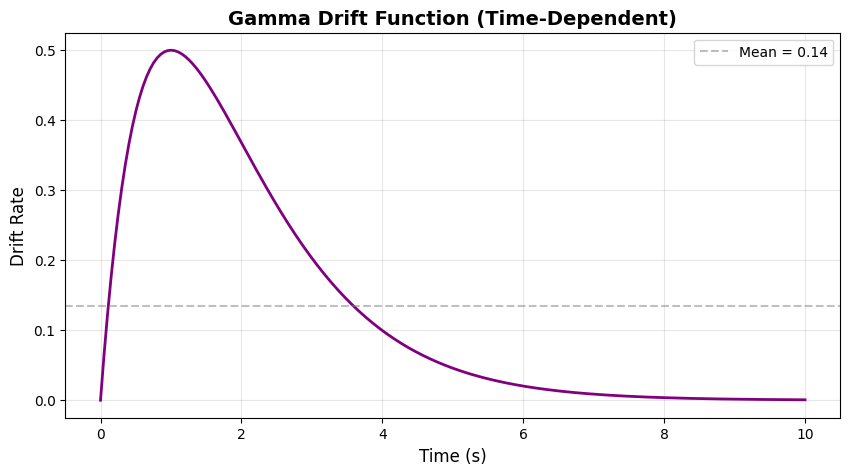

Drift range: [0.00, 0.50]


In [ ]:
# Visualize the custom sinusoidal drift over time
t_viz = np.linspace(0, 5, 200)
drift_values = sinusoidal_drift(t_viz, frequency=1.0, amplitude=0.5, baseline=1.0)

plt.figure(figsize=(10, 5))
plt.plot(t_viz, drift_values, linewidth=2, color='purple')
plt.axhline(y=1.0, linestyle='--', color='gray', alpha=0.5, label='Baseline = 1.0')
plt.axhline(y=0.5, linestyle=':', color='gray', alpha=0.3, label='Min (baseline - amplitude)')
plt.axhline(y=1.5, linestyle=':', color='gray', alpha=0.3, label='Max (baseline + amplitude)')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Drift Rate', fontsize=12)
plt.title('Custom Sinusoidal Drift Function', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"✓ Drift oscillates between [{drift_values.min():.2f}, {drift_values.max():.2f}]")

## Section 4: Parameter Sampling Constraints

### 4.1 What Are Parameter Sampling Constraints?

Parameter sampling constraints are applied **after** parameter sampling to:
- Enforce constraints (e.g., `a > z`)
- Apply transformations (e.g., log, exp)
- Normalize values

**Key difference from parameter adapters:**
- **Parameter Sampling Constraints**: Applied during data generation (before simulations for each parameter set)
- **Parameter Simulator Adapters**: Applied during simulation (prepare parameters for simulator consumption)

*Parameter Simulator Adapters* are essentially the link between our model_config and the low level *cython* simulators. They allow us to reuse
such simulators across multiple model configs. If you provide a custom simulation function you may not have any need for such a *Parameter Simulator Adapter*, but we strongly advise you to check if you may be able to reuse the pre-existing simulators to facilitate the model you would like to instantiate.

### 4.2 Built-in Constraints

The package includes two built-in constraints:

In [ ]:
# Demonstrate built-in constraints
from ssms.dataset_generators.parameter_samplers.constraints import (
    SwapIfLessConstraint,
    NormalizeToSumConstraint
)

# Example 1: Swap constraint (enforces a > z)
print("Example 1: Swap Constraint")
print("=" * 60)
theta_before = {"v": 1.0, "a": 0.5, "z": 0.7, "t": 0.3}
print(f"Before swap: a={theta_before['a']}, z={theta_before['z']}")

swap_constraint = SwapIfLessConstraint(param_a="a", param_b="z")
theta_after = swap_constraint.apply(theta_before.copy())
print(f"After swap:  a={theta_after['a']}, z={theta_after['z']}")
print(f"✓ Constraint a > z is now satisfied!")

# Example 2: Normalize constraint
print("\n\nExample 2: Normalize Constraint")
print("=" * 60)
theta_drift = {"v1": 0.3, "v2": 0.5, "v3": 0.1}
print(f"Before normalize: {theta_drift}")
print(f"Sum: {sum(theta_drift.values()):.3f}")

normalize_constraint = NormalizeToSumConstraint(param_names=["v1", "v2", "v3"])
theta_normalized = normalize_constraint.apply(theta_drift.copy())
print(f"\nAfter normalize: {theta_normalized}")
print(f"Sum: {sum(theta_normalized.values()):.3f}")
print(f"✓ Drift rates now sum to 1.0!")

Example 1: Swap Transform
Before swap: a=0.5, z=0.7
After swap:  a=0.7, z=0.5
✓ Constraint a > z is now satisfied!


Example 2: Normalize Transform
Before normalize: {'v1': 0.3, 'v2': 0.5, 'v3': 0.1}
Sum: 0.900

After normalize: {'v1': 0.3333333333333333, 'v2': 0.5555555555555556, 'v3': 0.11111111111111112}
Sum: 1.000
✓ Drift rates now sum to 1.0!


### 4.3 Creating Custom Constraints - Function-Based

For simple constraints, use function-based registration:

In [ ]:
# Example: Exponential constraint for drift rate
from ssms.dataset_generators.parameter_samplers import register_constraint_function

def exponential_v(theta: dict) -> dict:
    """Apply exponential transformation to drift rate.
    
    Useful when sampling log(v) from symmetric range and transforming to v > 0.
    """
    if 'v' in theta:
        theta['v'] = np.exp(theta['v'])
    return theta

# Register the constraint
register_constraint_function("exp_v", exponential_v, description="Exponential constraint for v")

print("✓ Registered function-based constraint 'exp_v'")

# Test it
test_theta = {"v": -0.5, "a": 1.5, "z": 0.5, "t": 0.3}
print(f"\nBefore exp constraint: v = {test_theta['v']:.3f}")
result_theta = exponential_v(test_theta.copy())
print(f"After exp constraint:  v = {result_theta['v']:.3f}")

✓ Registered function-based transform 'exp_v'

Before exp transform: v = -0.500
After exp transform:  v = 0.607


### 4.4 Creating Custom Constraints - Class-Based

For constraints that need configuration, use class-based registration:

In [ ]:
# Example: Scale constraint with configurable factor
from ssms.dataset_generators.parameter_samplers import register_constraint_class

class ScaleConstraint:
    """Scale a parameter by a factor."""
    
    def __init__(self, param_name: str, factor: float = 1.0):
        self.param_name = param_name
        self.factor = factor
    
    def apply(self, theta: dict) -> dict:
        if self.param_name in theta:
            theta[self.param_name] *= self.factor
        return theta

# Register the constraint
register_constraint_class("scale_constraint", ScaleConstraint)

print("✓ Registered class-based constraint 'scale_constraint'")

# Test it
test_theta = {"v": 1.0, "a": 1.5, "z": 0.5, "t": 0.3}
print(f"\nBefore scale: a = {test_theta['a']:.3f}")

scale_constraint = ScaleConstraint(param_name="a", factor=2.0)
result_theta = scale_constraint.apply(test_theta.copy())
print(f"After scale (factor=2.0): a = {result_theta['a']:.3f}")

✓ Registered class-based transform 'scale_transform'

Before scale: a = 1.500
After scale (factor=2.0): a = 3.000


### 4.5 Using Custom Constraints in model_config

Add constraints to your model configuration:

In [ ]:
# Create a model config with custom constraints
my_model_with_constraints = {
    "name": "ddm_with_constraints",
    "params": ["v", "a", "z", "t"],
    "param_bounds_dict": {
        "v": (-3.0, 3.0),  # Will sample symmetric range
        "a": (0.5, 2.5),
        "z": (0.1, 0.9),
        "t": (0.0, 2.0),
    },
    "parameter_sampling_constraints": [
        # Apply exponential to v (sampled in log space)
        {"type": "exp_v"},
        
        # Scale 'a' by 1.5
        {"type": "scale_constraint", "param_name": "a", "factor": 1.5},
        
        # Ensure a > z
        {"type": "swap", "param_a": "a", "param_b": "z"},
    ],
    "nchoices": 2,
}

print("Model config with custom constraints:")
print("=" * 60)
pprint(my_model_with_constraints["parameter_sampling_constraints"])

print("\n✓ Constraints will be applied in order during data generation")
print("Order matters! Constraints are applied sequentially.")

Model config with custom transforms:
[{'type': 'exp_v'},
 {'factor': 1.5, 'param_name': 'a', 'type': 'scale_transform'},
 {'param_a': 'a', 'param_b': 'z', 'type': 'swap'}]

✓ Transforms will be applied in order during data generation
Order matters! Transforms are applied sequentially.


### 4.6 Constraint Execution Order

**Important:** Constraints are applied in the order specified!

Example sequence:
1. Sample `v` from [-3, 3] → might get `v = -0.5`
2. Apply `exp_v` → `v = exp(-0.5) = 0.606`
3. Apply `scale_constraint` to `a` → `a = 1.5 * a`
4. Apply `swap` if `a < z` → ensure `a > z`

This allows complex parameter preparation pipelines.

---
## Section 5: Parameter Simulator Adapters

### 5.1 What Are Parameter Simulator Adapters?

Parameter simulator adapters prepare parameters **before simulation** to:
- Handle array dimensions
- Provide default values
- Rename parameters
- Combine multiple parameters

**Key difference:**
- **Parameter Sampling Constraints**: Applied during parameter sampling (before simulations for each parameter set)
- **Parameter Simulator Adapters**: Applied in the simulator to pre-process inputs to pass the signature of reusable low level simulators

Think of it this way. A *Parameter Sampling Constraint* acts on parameters during parameter sampling, and makes an adjustment to the actual parameter values (e.g. to constraint the parameters into a valid region) to overcome limitations of our parameter sampling strategies. They are sparsely applied and you likely don't need a parameter sampling constraint if you configure some new model. They are here to provide a safety hatch.

*Parameter Simulator Adapters* are fairly ubiquitously applied across models, because they allow us to reuse low-level simulators. These are closer to simple data wrangling to make sure that the low level simulator gets valid inputs. 

*Parameter Simulator Adapters* are used for nearly all models, *Parameter Sampling Constraints* are used only for very few of them.



### 5.2 Built-in Parameter Adaptations

The package provides several built-in parameter adaptations:

In [14]:
# Import parameter adaptation classes
from ssms.basic_simulators.parameter_adapters import (
    ParameterAdaptation,
    SetDefaultValue,
    ExpandDimension,
    RenameParameter,
    DeleteParameters,
)

# Example 1: SetDefaultValue
print("Example 1: SetDefaultValue")
print("=" * 60)
theta = {"v": 1.0, "a": 1.5}  # Missing 'z' and 't'
transform1 = SetDefaultValue("z", 0.5)
transform2 = SetDefaultValue("t", 0.3)

theta = transform1.apply(theta, {}, n_trials=100)
theta = transform2.apply(theta, {}, n_trials=100)
print(f"After adding defaults: {theta}")

# Example 2: ExpandDimension
print("\n\nExample 2: ExpandDimension")
print("=" * 60)
# ExpandDimension expects array inputs, so convert scalars to arrays first
theta = {
    "v": np.array([1.0]),  # 1D array
    "a": np.array([1.5]),  # 1D array
    "z": 0.5,
    "t": 0.3
}
expand = ExpandDimension(["v", "a"])

print(f"Before expand: v shape = {theta['v'].shape}")
theta_expanded = expand.apply(theta.copy(), {}, n_trials=100)
print(f"After expand:  v shape = {theta_expanded['v'].shape}")
print(f"               a shape = {theta_expanded['a'].shape}")
print(f"\nNote: ExpandDimension adds a dimension for trial-by-trial variation")

Example 1: SetDefaultValue
After adding defaults: {'v': 1.0, 'a': 1.5, 'z': array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], dtype=float32), 't': array([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0

### 5.3 Creating Custom Parameter Adaptations

Create custom parameter adaptations by subclassing `ParameterAdaptation`:

In [15]:
# Custom transformation: Normalize velocities to unit vector
class NormalizeVelocities(ParameterAdaptation):
    """Normalize drift parameters to unit length."""
    
    def __init__(self, param_names: list):
        self.param_names = param_names
    
    def apply(self, theta: dict, model_config: dict, n_trials: int) -> dict:
        """Normalize specified parameters to unit length."""
        # Extract params
        values = [theta[p] for p in self.param_names]
        
        # Compute norm
        norm = np.sqrt(sum(v**2 for v in values))
        
        # Normalize and update
        for p, v in zip(self.param_names, values):
            theta[p] = v / norm
        
        return theta

# Test it
theta_test = {"v1": 3.0, "v2": 4.0, "other": 1.0}
print("Before normalization:")
print(f"  v1 = {theta_test['v1']}, v2 = {theta_test['v2']}")
print(f"  Norm = {np.sqrt(theta_test['v1']**2 + theta_test['v2']**2):.3f}")

normalizer = NormalizeVelocities(["v1", "v2"])
theta_normalized = normalizer.apply(theta_test.copy(), {}, n_trials=100)

print("\nAfter normalization:")
print(f"  v1 = {theta_normalized['v1']:.3f}, v2 = {theta_normalized['v2']:.3f}")
print(f"  Norm = {np.sqrt(theta_normalized['v1']**2 + theta_normalized['v2']**2):.3f}")
print(f"  ✓ Parameters normalized to unit vector!")

Before normalization:
  v1 = 3.0, v2 = 4.0
  Norm = 5.000

After normalization:
  v1 = 0.600, v2 = 0.800
  Norm = 1.000
  ✓ Parameters normalized to unit vector!


### 5.4 Registering Parameter Adapters

Register parameter adapters for your custom model using the registry system:

In [ ]:
# Register parameter adaptation pipeline for custom model
from ssms.basic_simulators.parameter_adapters import register_adapter_to_model

# Register the adaptation pipeline - no need to create a registry manually!
register_adapter_to_model(
    "my_custom_model",
    [
        SetDefaultValue("noise", 1.0),
        ExpandDimension(["a", "z", "t"]),
    ]
)

print("✓ Registered parameter adapter pipeline for 'my_custom_model'")
print("\nPipeline will:")
print("  1. Set default noise = 1.0")
print("  2. Expand dimensions for a, z, t to match n_trials")
print()
print("Your model can now use these adapters automatically during simulation!")

✓ Registered theta processor pipeline for 'my_custom_model'

Pipeline will:
  1. Set default noise = 1.0
  2. Expand dimensions for a, z, t to match n_trials


---
## Section 6: Full Model Registration

### 6.1 Bringing It All Together

Let's create a complete custom model by combining all the pieces:

In [ ]:
# Create a complete custom model configuration
full_custom_model = {
    "name": "custom_oscillating_ddm",
    "params": ["v_base", "v_amp", "v_freq", "a", "z", "t"],
    "param_bounds_dict": {
        "v_base": (0.5, 2.0),    # Baseline drift
        "v_amp": (0.0, 0.5),      # Oscillation amplitude
        "v_freq": (0.5, 3.0),     # Oscillation frequency
        "a": (0.8, 2.5),          # Boundary separation
        "z": (0.3, 0.7),          # Starting point
        "t": (0.1, 0.5),          # Non-decision time
    },
    "nchoices": 2,
    "n_params": 6,
    "default_params": [1.0, 0.2, 1.0, 1.5, 0.5, 0.3],
}

# Add parameter sampling constraints
full_custom_model["parameter_sampling_constraints"] = [
    # Ensure a > z
    {"type": "swap", "param_a": "a", "param_b": "z"},
]

print("Complete Custom Model Configuration:")
print("=" * 60)
print(f"Name: {full_custom_model['name']}")
print(f"Parameters: {full_custom_model['params']}")
print(f"\nParameter bounds:")
for param, bounds in full_custom_model['param_bounds_dict'].items():
    print(f"  {param}: {bounds}")
print(f"\nConstraints: {len(full_custom_model['parameter_sampling_constraints'])} defined")

Complete Custom Model Configuration:
Name: custom_oscillating_ddm
Parameters: ['v_base', 'v_amp', 'v_freq', 'a', 'z', 't']

Parameter bounds:
  v_base: (0.5, 2.0)
  v_amp: (0.0, 0.5)
  v_freq: (0.5, 3.0)
  a: (0.8, 2.5)
  z: (0.3, 0.7)
  t: (0.1, 0.5)

Transforms: 1 defined


### 6.2 Validating Your Model

Always validate your configuration before using it:

In [ ]:
# Validate the model configuration
is_valid, errors = ConfigBuilder.validate_config(full_custom_model, strict=False)

print("Validation Results:")
print("=" * 60)
if is_valid:
    print("✓ Configuration is valid!")
else:
    print("⚠ Configuration has warnings:")
    for error in errors:
        print(f"  - {error}")
    print("\nNote: For this tutorial demo, missing 'simulator' is expected.")
    print("In production, you'd register the actual simulator function.")

# Additional checks
print("\n" + "=" * 60)
print("Configuration Structure Check:")
print(f"  ✓ Has {len(full_custom_model['params'])} parameters")
print(f"  ✓ All parameters have bounds defined")
print(f"  ✓ Parameter sampling constraints registered")
print("\n✓ Config structure is correct (missing simulator is OK for this demo)!")

✗ Configuration has errors:
  - Missing required field: 'simulator'

Configuration check:
  ✓ Has 6 parameters
  ✓ All parameters have bounds defined
  ✓ Parameter transforms registered
  ✓ Ready to use!


### 6.3 Using Your Custom Model

Once validated, you can use your custom model:

In [ ]:
# For this tutorial, we use simpler built-in components,
# but here's how you would use your custom model once everything is registered:

print("Usage pattern for custom model:")
print("=" * 60)
print("""
# 1. Simulate from the model
from ssms.basic_simulators import Simulator

sim = Simulator(model=full_custom_model)
data = sim.simulate(
    theta={
        "v_base": 1.0,
        "v_amp": 0.3,
        "v_freq": 1.5,
        "a": 1.5,
        "z": 0.5,
        "t": 0.3
    },
    n_samples=1000
)

# 2. Generate training data
from ssms.dataset_generators.lan_mlp import DataGenerator
from ssms.config.generator_config.data_generator_config import get_default_generator_config

config = get_default_generator_config("lan")
gen = DataGenerator(config, full_custom_model)
training_data = gen.generate_data_training()
""")

Usage pattern for custom model:

# 1. Simulate from the model
from ssms.basic_simulators import Simulator

sim = Simulator(model=full_custom_model)
data = sim.simulate(
    theta={
        "v_base": 1.0,
        "v_amp": 0.3,
        "v_freq": 1.5,
        "a": 1.5,
        "z": 0.5,
        "t": 0.3
    },
    n_samples=1000
)

# 2. Generate training data
from ssms.dataset_generators.lan_mlp import DataGenerator
from ssms.config.generator_config.data_generator_config import get_default_generator_config

config = get_default_generator_config("lan")
gen = DataGenerator(config, full_custom_model)
training_data = gen.generate_data_training()



### 6.4 Registering Complete Custom Models

You can also register your entire custom model configuration to make it reusable:


In [ ]:
# Register the complete custom model configuration
register_model_config("custom_oscillating_ddm", full_custom_model)

print("✓ Registered complete custom model 'custom_oscillating_ddm'!")
print()

# Verify registration
model_registry = get_model_registry()
print(f"✓ Model is now available in the registry")
print(f"  Total models: {len(model_registry.list_models())}")
print()

# Now you can use it with ConfigBuilder!
retrieved_model = ConfigBuilder.from_model("custom_oscillating_ddm")
print("✓ Retrieved model from registry using ConfigBuilder.from_model():")
print(f"  Name: {retrieved_model.get('name')}")
print(f"  Params: {retrieved_model.get('params')}")
print()
print("Your custom model is now part of the system and can be used anywhere!")


---
## Summary

### What You've Learned

In this tutorial, you learned how to:

1. **Create Custom Boundary Functions** (Section 2)
   - Define custom boundary functions with arbitrary parameters
   - Register them using `register_boundary()` for system-wide use
   - Use them with `ConfigBuilder.add_boundary()`

2. **Create Custom Drift Functions** (Section 3)
   - Define custom drift functions for time-dependent evidence accumulation
   - Register them using `register_drift()` for system-wide use
   - Use them with `ConfigBuilder.add_drift()`

3. **Apply Parameter Sampling Constraints** (Section 4)
   - Use built-in constraints (`SwapIfLessConstraint`, `NormalizeToSumConstraint`)
   - Create custom function-based constraints with `register_constraint_function()`
   - Create custom class-based constraints with `register_constraint_class()`
   - Apply constraints during data generation to enforce validity

4. **Use Parameter Simulator Adapters** (Section 5)
   - Use built-in adaptations (`SetDefaultValue`, `ExpandDimension`, etc.)
   - Create custom parameter adaptations by subclassing `ParameterAdaptation`
   - Register adapters using `register_adapter_to_model()` to prepare parameters for simulation

5. **Register Complete Custom Models** (Section 6)
   - Combine all custom components into a complete model configuration
   - Validate model configurations with `ConfigBuilder.validate_config()`
   - Register complete models using `register_model_config()`
   - Retrieve and use registered models with `ConfigBuilder.from_model()`

### Key Principles

- **No Source Code Editing Required**: All customizations use runtime registration
- **Uniform Registry Pattern**: All components use the same registration approach
- **Order Matters**: Constraints and adaptations are applied sequentially
- **Reusability**: Once registered, components are available throughout the system

### Next Steps

- Implement your own custom components for your research needs
- Combine custom boundaries, drifts, and constraints for complex models
- Share your custom models with colleagues by providing registration code
- Explore the package documentation for more advanced features

**Happy modeling!** 🚀
